# AdPMCMC on model $M_2$

In [13]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import scipy
from scipy.stats import invgamma
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn
%pylab inline

from numba import jit
from numpy import arange

Populating the interactive namespace from numpy and matplotlib


We begin by considering the model $M_0$ : 
\begin{equation}
\log N_{t+1} = \log N_t + b_0 + \epsilon_t
\end{equation}

with $\epsilon_t \sim \mathcal{N}(0, \sigma_\epsilon^2)$. 

We put a Gaussian prior on the maximum per-individual growth rate parameter : $b_0 \sim \mathcal{N}(0, 1)$.
We use inverse Gamma priors for the variance noises :

$\sigma_\epsilon^2 \sim \mathcal{IG}(\alpha_\epsilon, \beta_\epsilon)$

$\sigma_w^2 \sim \mathcal{IG}(\alpha_w, \beta_w)$

with hyperpameters $\alpha_\epsilon=\alpha_w=\frac{T}{2}$ and $\beta_\epsilon=\beta_w=\frac{2(\alpha_\epsilon-1)}{10}$.

For synthetic data simulation, the authors set :

In [14]:
# model parameters
b_0 = 0.15 
b_2 = -0.125
b_3 = 0.1
sigma_w = 0.39 # observation noise
sigma_eps = 0.47 # process noise
n_0 = 1.27 # starting point of latent variable
T = 30 # time horizon

# inverse gamma prior hyperparameters
alpha_eps = alpha_w =  T/2 
beta_eps = beta_w = 2*(alpha_eps - 1)/10

In [3]:
@jit
def trajectorySimulationM0(T):
    """
    Simulates latent variable and observation trajectories of horizon T for the M_0 model
    """
    
    # Initialization of latent variable trajectory
    log_N = np.zeros(T+1)
    
    # Arbitrary initialization (found in the paper p. 12)
    log_N[0] = np.log(n_0)
    
    # Latent variable simulation
    for t in range(T):
        log_N[t+1] = log_N[t] + b_0 + np.random.normal(0, sigma_eps)
    
    # Observation variable
    Y = np.exp(log_N) + np.random.normal(0, sigma_w, T+1)
    
    return log_N, Y

In [15]:
@jit
def trajectorySimulationM2(T):
    """
    Simulates latent variable and observation trajectories of horizon T for the M_0 model
    """
    
    # Initialization of latent variable trajectory
    log_N = np.zeros(T+1)
    
    # Arbitrary initialization (found in the paper p. 12)
    log_N[0] = np.log(n_0)
    
    # Latent variable simulation
    for t in range(T):
        log_N[t+1] = log_N[t] + b_0 + b_2*np.exp(log_N[t])**b_3 +np.random.normal(0, sigma_eps)
    
    # Observation variable
    Y = np.exp(log_N) + np.random.normal(0, sigma_w, T+1)
    
    return log_N, Y

Problem : $g_t$ from the observation process is not defined in the paper.

Since, in the paper, $p(y_t | n_t, \sigma^2_w)$ is assumed to be the density of a Gaussian distribution with mean $n_t$ and variance $\sigma^2_w$, I assume $g_t$ is the identity function.

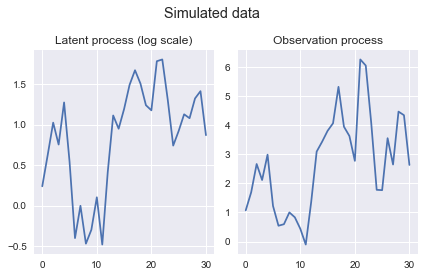

In [36]:
# Simulate and plot a trajectory
log_N, Y = trajectorySimulationM2(T)

f, (ax1, ax2) = plt.subplots(1, 2)
st = f.suptitle("Simulated data", fontsize="x-large")

ax1.plot(log_N)
ax1.set_title('Latent process (log scale)')
ax2.plot(Y)
ax2.set_title('Observation process')

plt.tight_layout()

st.set_y(0.95)
f.subplots_adjust(top=0.80)

## MCMC proposal for $\theta$

In [28]:
# non-adaptive theta proposal
@jit
def nonAdaptiveThetaProposal(theta):
    """ 
    Non-adaptive Gaussian kernel for parameter proposal
    """
    d = theta.shape[0]
    return np.random.multivariate_normal(theta, (0.1)**2 / d * np.eye(d))

In [29]:
# adaptive theta proposal
def adaptiveThetaProposal(thetas):
    """ 
    Adaptive Gaussian kernel for parameter proposal
    See algorithm 2 of paper
    """
    emp_cov = np.cov(thetas, rowvar=False)
    theta = thetas[-1]
    d = theta.shape[0]
    return np.random.multivariate_normal(theta, 2.38**2 / d * emp_cov)

## SMC sampler for $n_{1:T}$

In [30]:
def g(y, log_n, sigma_w):
    """
    Gaussian log-density for observation process
    """
    return -0.5*np.log(2*np.pi*sigma_w**2) - (y - np.exp(log_n))**2/(2*sigma_w**2)

@jit
def stratifiedResampling(weights):
    """
    Stratified resampling
    Returns drawn indexes as a list
    weights needs to be a numpy array
    """
    n_samples = weights.shape[0]
        
    # Generate n_samples sorted uniforms with stratified sampling
    sorted_uniforms = np.zeros(n_samples)
    for n in range(n_samples):
        sorted_uniforms[n] = np.random.uniform(n/n_samples, (n+1)/n_samples)
        
    sampled_indexes = []
    j, partial_sum_weights = 0, weights[0]
    for n in range(n_samples):
        while sorted_uniforms[n] > partial_sum_weights:
            j += 1
            partial_sum_weights += weights[j]
        sampled_indexes += [j]
        
    return sampled_indexes

def q(theta_prev, theta):
    """
    Density of non-adaptive proposal kernel
    """
    d = theta.shape[0]
    return scipy.stats.multivariate_normal.pdf(theta, theta_prev, (0.1)**2/d * np.eye(d))

In the paper, there seems to be a simulation of $b_0$ per particles, see Algorithm 1, p.31, this seems odd.

See "Log-PF: Particle Filtering in Logarithm Domain" for log-normalization of weights

In [31]:
# Random initialization
sigma_eps = (invgamma.rvs(a=alpha_eps, scale=beta_eps))**(1 / 2)
sigma_w = invgamma.rvs(a=alpha_w, scale=beta_w)**(1 / 2)
sigma_eps, sigma_w

(0.44253068453234556, 0.39105874761780185)

In [54]:
# n | theta proposal
@jit
def SMC_M0(y, T, L, n_0, b_0, sigma_eps, sigma_w):
    """
    Particle filter 
    """
    
    # L is the number of particles
    log_particles = np.zeros((T, L))
    
    w = np.zeros((T, L))
    
    # Weights matrix
    W = np.zeros((T, L))
        
    # Log-weights matrix
    log_W = np.zeros((T, L))
    
    # Initial propagation
    log_particles[0, :] = np.log(n_0) + b_0 + np.random.normal(loc=0, scale=sigma_eps, size=L)
    
    # Not sure about W initialization
    for l in range(L):
        w[0, l] = g(y[0], log_particles[0, l], sigma_w)
        log_W[0, l] = w[0, l]
    
    # Weight normalization (log scale)
    log_W[0, :] -= np.max(log_W[0, :]) # scaling   
    log_sum_of_weights = np.log(sum(np.exp(log_W[0, :]))) 
    log_W[0, :] -= log_sum_of_weights
    
    W[0, :] = np.exp(W[0, :])
    
    for t in range(1, T):
        for l in range(L):
            # Propagation
            log_particles[t, l] = log_particles[t-1, l] + b_0 + np.random.normal(0, sigma_eps)
                        
            # Weight computation
            w[t, l] = g(y[t], log_particles[t, l], sigma_w)
            log_W[t, l] = log_W[t-1, l] + w[t, l]
                
        # Weight normalization (log scale)
        log_W[t, :] -= np.max(log_W[t, :]) # scaling   
        log_sum_of_weights = np.log(sum(np.exp(log_W[t, :]))) 
        log_W[t, :] -= log_sum_of_weights
                            
        # Adaptive resampling : sample if ESS < 80% of number of particles
        ESS = 1/sum(np.exp(log_W[t, :])**2)
        
        # Pb : ESS is always < 0.8*L 
                
        if ESS < 0.8*L:
            # resample indexes according to the normalized importance weights
            resampled_indexes = stratifiedResampling(np.exp(log_W[t, :]))
            log_particles[t, :] = log_particles[t, resampled_indexes]
            log_W[t, :] = np.log(np.ones(L)/L) # the new particles have equal weight
        
        W[t, :] = np.exp(log_W[t, :])
        
    # Evaluate marginal likelihood
        
    marginal_likelihood = np.sum(np.log(np.sum(np.exp(w), axis=1)/L))     
        
    return log_particles, W, log_marginal_likelihood

In [55]:
# n | theta proposal
@jit
def SMC_M2(y, T, L, n_0, b_0, sigma_eps, sigma_w):
    """
    Particle filter 
    """
    
    # L is the number of particles
    log_particles = np.zeros((T, L))
    
    w = np.zeros((T, L))
    
    # Weights matrix
    W = np.zeros((T, L))
        
    # Log-weights matrix
    log_W = np.zeros((T, L))
    
    # Initial propagation
    log_particles[0, :] = np.log(n_0) + b_0 + b_2*n_0**b_3 + np.random.normal(loc=0, scale=sigma_eps, size=L)
    
    # Not sure about W initialization
    for l in range(L):
        w[0, l] = g(y[0], log_particles[0, l], sigma_w)
        log_W[0, l] = w[0, l]
    
    # Weight normalization (log scale)
    log_W[0, :] -= np.max(log_W[0, :]) # scaling   
    log_sum_of_weights = np.log(sum(np.exp(log_W[0, :]))) 
    log_W[0, :] -= log_sum_of_weights
    
    W[0, :] = np.exp(W[0, :])
    
    for t in range(1, T):
        for l in range(L):
            # Propagation
            log_particles[t, l] = log_particles[t-1, l] + b_0 + b_2*np.exp(log_particles[t-1, l])**b_3 + np.random.normal(0, sigma_eps)
                        
            # Weight computation
            w[t, l] = g(y[t], log_particles[t, l], sigma_w)
            log_W[t, l] = log_W[t-1, l] + w[t, l]
                
        # Weight normalization (log scale)
        log_W[t, :] -= np.max(log_W[t, :]) # scaling   
        log_sum_of_weights = np.log(sum(np.exp(log_W[t, :]))) 
        log_W[t, :] -= log_sum_of_weights
                            
        # Adaptive resampling : sample if ESS < 80% of number of particles
        ESS = 1/sum(np.exp(log_W[t, :])**2)
        
        # Pb : ESS is always < 0.8*L 
                
        if ESS < 0.8*L:
            # resample indexes according to the normalized importance weights
            resampled_indexes = stratifiedResampling(np.exp(log_W[t, :]))
            log_particles[t, :] = log_particles[t, resampled_indexes]
            log_W[t, :] = np.log(np.ones(L)/L) # the new particles have equal weight
        
        W[t, :] = np.exp(log_W[t, :])
        
    # Evaluate marginal likelihood
        
    log_marginal_likelihood = np.sum(np.log(np.sum(np.exp(w), axis=1)/L))   
        
    return log_particles, W, log_marginal_likelihood

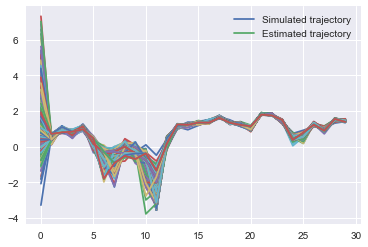

In [58]:
L = 500

log_particles, W, log_marginal_likelihood = SMC_M2(Y, T, L, n_0, b_0, sigma_eps, sigma_w)

log_particles_averaged = [np.average(log_particles[t, :], weights=W[t, :], axis=0) 
                          for t in range(T)]

plt.plot(log_N[:-1])
plt.plot(log_particles) 
plt.legend(["Simulated trajectory", "Estimated trajectory"])

## Stage 3 : Generic PMCMC

There seems to be a pb with marginal_eps_ratio and marginal_w_ratio

In [81]:
n_steps = 1000
L = 500

# draw uniforms for accept-reject procedure
uniforms = np.random.uniform(0, 1, n_steps)

# adaptive rate 
w = 0  # set to 0 -> non-adaptive proposal

# trajectory history
N_hist = []

# Theta initialization
b_0 = np.random.normal(0, 1)
sigma_eps = invgamma.rvs(a=alpha_eps, scale=beta_eps)**(1 / 2)
sigma_w = invgamma.rvs(a=alpha_w, scale=beta_w)**(1 / 2)

theta = np.array([b_0, sigma_eps, sigma_w])
theta_hist = [theta]

for j in range(n_steps):
    
    # draw candidate theta wrt non adaptive proposal
    if np.random.rand() < 1 - w:
        theta = nonAdaptiveThetaProposal(theta)
    else:
        theta = adaptiveThetaProposal(theta_hist)
        
    # unpack theta
    b_0, sigma_eps, sigma_w = theta
    
    #what we really care about is sigma**2
    sigma_eps, sigma_w = np.abs(sigma_eps), np.abs(sigma_w) 
    theta = np.array([b_0, sigma_eps, sigma_w])
    
    # run SMC
    log_particles, W, log_marginal_likelihood = SMC(
        Y, T, L, n_0, b_0, sigma_eps, sigma_w)

    # sample a candidate path
    idx = np.random.choice(a=L, size=1, p=W[-1])[0]
    candidate_path = log_particles[:, idx]

    # compute acceptance proba
    if j == 0:
        alpha = 1
    else:
        
        # last accepted theta
        b_0_prev, sigma_eps_prev, sigma_w_prev = theta_hist[-1]
        
        marginal_likelihood_ratio = np.exp(log_marginal_likelihood - prev_log_marginal_likelihood)
        
        marginal_b_ratio = np.exp((b_0_prev**2 - b_0**2) / 2)
        
        marginal_eps_ratio = (invgamma.pdf(x=sigma_eps**2, a=alpha_eps, scale=beta_eps) / 
                              invgamma.pdf(x=sigma_eps_prev**2, a=alpha_eps, scale=beta_eps))
        
        marginal_w_ratio = (invgamma.pdf(x=sigma_w**2, a=alpha_w, scale=beta_w) / 
                            invgamma.pdf(x=sigma_w_prev**2, a=alpha_w, scale=beta_w))
        
        theta_proposal_ratio = q(theta, theta_hist[-1]) / q(theta_hist[-1], theta)
        
        
        
        
        alpha = (marginal_likelihood_ratio * marginal_b_ratio * 
                 marginal_eps_ratio * marginal_w_ratio * theta_proposal_ratio)
        
        #print('Alpha : {}'.format(alpha))
        #print(marginal_likelihood_ratio)
        #print(marginal_b_ratio)
        #print(marginal_eps_ratio)
        #print(marginal_w_ratio)
        #print(theta_proposal_ratio)
        
    if uniforms[j] < alpha:
        prev_log_marginal_likelihood = log_marginal_likelihood
        theta_hist.append(theta)
        N_hist.append(candidate_path)

In [82]:
theta_history = theta_hist
len(theta_history)

9

In [ ]:
theta_hist = np.array(theta_hist)
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
st = f.suptitle("estimated parameters", fontsize="xx-large")

f.set_figwidth(20)
f.set_figheight(8)
ax1.plot(np.arange(len(theta_hist)), np.cumsum(theta_hist[:, 0]) / (np.arange(len(theta_hist)) + 1) )
ax1.axhline(y=0.15, color='r', linestyle='--')

ax1.set_title('b0')
ax2.plot(np.arange(len(theta_hist)), np.cumsum(theta_hist[:, 1]) / (np.arange(len(theta_hist)) + 1))
ax2.axhline(y=0.47, color='r', linestyle='--')
ax2.set_title('sigma eps')

ax3.plot(np.arange(len(theta_hist)),np.cumsum(theta_hist[:, 2]) / (np.arange(len(theta_hist)) + 1))
ax3.axhline(y=0.39, color='r', linestyle='--')
ax3.set_title('sigma w')